In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter, MaxNLocator
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

## Widmark Equation

(Dose in grams/(Body weight in grams x Distribution ratio "r"))x100 where r(male)=.68 r(female)=.55 and assuming an average constant rate of -0.016 BAC per hour.

[Source](https://alcohol.indianapolis.iu.edu/calculators/bac.html)

In [8]:
def calculate_bac(gender_male, weight_grams, ethanol_grams, hours_since_drinking=0):
    if gender_male == 1:
        r = 0.68
    else:
        r = 0.55

    bac = (ethanol_grams) * 100 / (weight_grams * r) - 0.015 * hours_since_drinking
    bac = max(bac, 0)
    bac = round(bac, 4)
    return bac

[0.2126, 0.0877, 0.4591, 0.1891, 0.0792, 0.1571, 0.1347, 0.1297, 0.0962, 0.0825, 0.1727, 0.1621, 0.2192, 0.1292, 0.0277, 0.1037]
Mean Squared Error: 0.009477784375
R² Score: -4.188863986313088


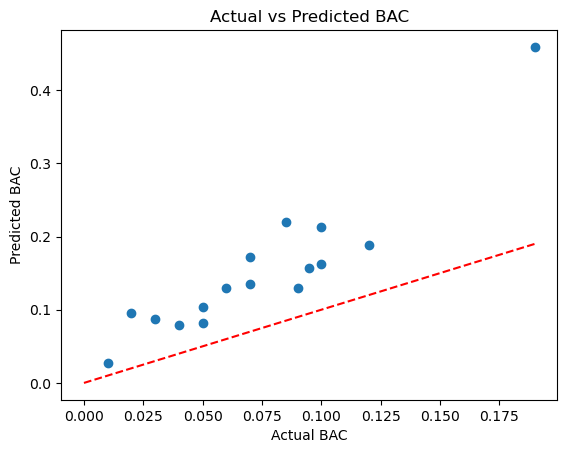

In [10]:
dataset = pd.read_csv('../data/processed/ohio_bac_dataset_processed.csv')
results = []
for index, row in dataset.iterrows():
    gender = row['Gender_male']
    weight = row['Bodyweight_grams']
    ethanol = row['Ethanol_grams']
    bac = calculate_bac(gender, weight, ethanol, hours_since_drinking=0)
    results.append(bac)
print(results)

actual_bac = dataset['BAC']

# Predicted BAC values (your results list)

# Calculate MSE and R²
mse = mean_squared_error(actual_bac, results)
r2 = r2_score(actual_bac, results)

print(f'Mean Squared Error: {mse}')
print(f'R² Score: {r2}')

# Plot Actual vs Predicted
plt.scatter(actual_bac, results)
plt.xlabel('Actual BAC')
plt.ylabel('Predicted BAC')
plt.title('Actual vs Predicted BAC')
plt.plot([0, max(actual_bac)], [0, max(actual_bac)], color='red', linestyle='--')  # Perfect prediction line
plt.show()

Making 10000 different models for each, then creating a distrubtion on how well the model is based on the r-squared value

We can see the ohio dataset is consistently better, so we choose to use this dataset and it's predicted model.


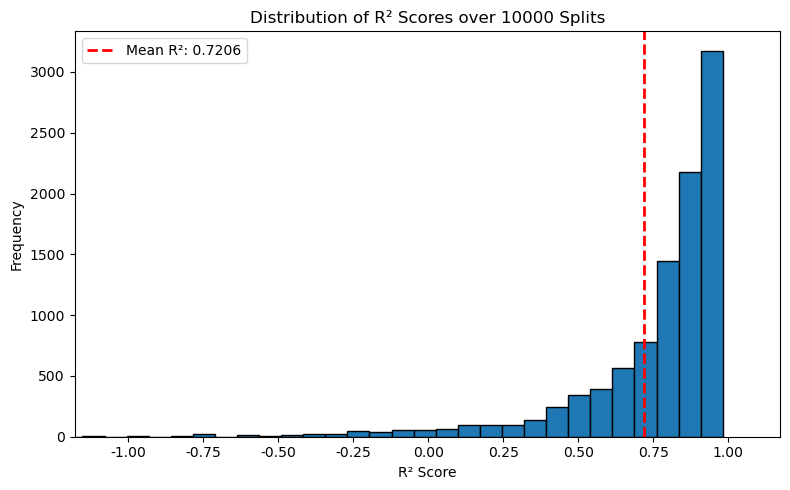

Mean R²: 0.7206
Standard Deviation of R²: 0.5103


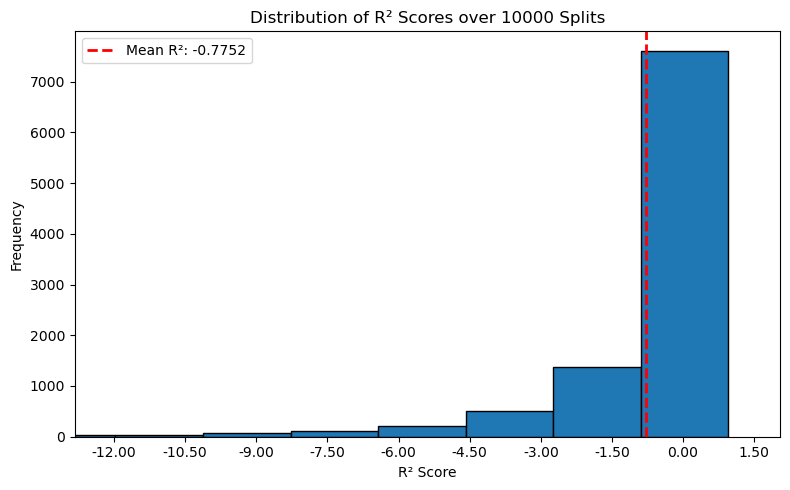

Mean R²: -0.7752
Standard Deviation of R²: 3.1877


In [11]:
def rsquared_distribution(file_path, features, target_column_name, iterations=10000):
    dataset = pd.read_csv(file_path)
    X = dataset[features]
    Y = dataset[target_column_name]

    r2_scores = []

    for _ in range(iterations):
        X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
        model = LinearRegression()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        r2 = r2_score(y_test, y_pred)
        r2_scores.append(r2)

    r2_scores = np.array(r2_scores)
    mean_r2 = np.mean(r2_scores)
    std_r2 = np.std(r2_scores)

    lower_bound = np.percentile(r2_scores, 1)
    upper_bound = np.percentile(r2_scores, 99)
    range_padding = (upper_bound - lower_bound) * 0.1 # what is this?

    # Plot
    plt.figure(figsize=(8,5))
    num_bins = min(100, int(np.sqrt(iterations)))
    plt.hist(r2_scores, bins=num_bins, edgecolor='black')
    plt.xlabel('R² Score')
    plt.ylabel('Frequency')
    plt.title(f'Distribution of R² Scores over {iterations} Splits')

    plt.axvline(mean_r2, color='red', linestyle='dashed', linewidth=2, label=f'Mean R²: {mean_r2:.4f}')
    plt.legend()

    plt.xlim(lower_bound - range_padding, upper_bound + range_padding)

    plt.gca().xaxis.set_major_locator(MaxNLocator(nbins=10, prune='both'))
    plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%.2f'))

    plt.tight_layout()
    plt.show()

    print(f"Mean R²: {mean_r2:.4f}")
    print(f"Standard Deviation of R²: {std_r2:.4f}")

# Example usage
rsquared_distribution('../data/processed/ohio_bac_dataset_processed.csv',
                      features=['Gender_male', 'Bodyweight_grams', 'Ethanol_grams'],
                      target_column_name='BAC', iterations=10000)

rsquared_distribution('../data/processed/australia_bac_dataset_processed.csv',
                      features=['Gender_male', 'Bodyweight_grams', 'Ethanol_grams', 'Age'],
                      target_column_name='1hr-BAC', iterations=10000)


Saving BAC model into outputs folder with the name BAC_model